测试数据和训练数据分组，数据分batch

In [1]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    # 验证集
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    # 测试集
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

111
31
15


In [2]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads, dropout_rate = 0.5):
        super(TransformerModel, self).__init__()
        """
        分类任务  params:
        input_dim           : 输入维度
        output_dim          : 输出的维度,类别数
        hidden_dim          : 注意力维度
        num_layers          : Transformer编码器层数
        num_heads           : 多头注意力头数
        dropout_rate          随机丢弃神经元的概率
        """
        # 批次量大小
        # 参数
        # Transformer编码器 layers
        self.hidden_dim = hidden_dim
        # Time Transformer layers
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(input_dim, num_heads, hidden_dim, dropout=0.5, batch_first=True),
            num_layers
        )
      
        self.norm = nn.LayerNorm(input_dim)
        # 平局池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        # 把数据进行堆叠 1*1024 ->  32 * 32
        # 当然， 还可以 堆叠 为其他形状的矩阵
        input_seq = input_seq.view(batch_size, 32, 32) 
     
        # 送入 transformer层
        # 在PyTorch中，transformer模型的性能与batch_first参数的设置相关。
        # 当batch_first为True时，输入的形状应为(batch, sequence, feature)，这种设置在某些情况下可以提高推理性能。
        transformer_output = self.transformer(input_seq)  #  torch.Size([32, 32, 32])
        x = self.norm(transformer_output)  # B L C  torch.Size([32, 32, 32])
        x = self.avgpool(x.transpose(1, 2))  # B C 1  torch.Size([32, 32, 32])
        flat_tensor = x.view(batch_size, -1) # torch.Size([32, 32])
        output = self.fc(flat_tensor)  # torch.Size([32, 10])  
        return output

In [3]:
# 模型参数
input_dim = 32 # 输入维度 把数据进行堆叠 1*1024 ->  32 * 32
hidden_dim = 128  # 注意力维度
output_dim  = 5  # 输出维度
num_layers = 4   # 编码器层数
num_heads = 8    # 多头注意力头数
# 模型
model = TransformerModel(input_dim, output_dim, hidden_dim, num_layers, num_heads)  
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)  # 优化器
# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

  3072
    96
  1024
    32
  4096
   128
  4096
    32
    32
    32
    32
    32
  3072
    96
  1024
    32
  4096
   128
  4096
    32
    32
    32
    32
    32
  3072
    96
  1024
    32
  4096
   128
  4096
    32
    32
    32
    32
    32
  3072
    96
  1024
    32
  4096
   128
  4096
    32
    32
    32
    32
    32
    32
    32
   160
     5
______
 51045


In [4]:
print(model)

TransformerModel(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=128, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=128, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)


In [ ]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            # 将模型设置为评估模式
            model.eval()
            loss_validate = 0.
            correct_validate = 0
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

    
    # 保存最后的参数
    # torch.save(model, 'final_model_transformer.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_transformer.pt')
   
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)



batch_size = 64
epochs = 50
# 模型训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

Epoch:  1 train_Loss: 1.26691424 train_Accuracy:0.4507
Epoch:  1 val_Loss:1.01441481,  validate_Acc:0.5207
Epoch:  2 train_Loss: 0.89601799 train_Accuracy:0.6023
Epoch:  2 val_Loss:0.83777131,  validate_Acc:0.5726
Epoch:  3 train_Loss: 0.75747906 train_Accuracy:0.6444
Epoch:  3 val_Loss:0.99394352,  validate_Acc:0.5131
Epoch:  4 train_Loss: 0.68212023 train_Accuracy:0.6664
Epoch:  4 val_Loss:0.98270591,  validate_Acc:0.5146
Epoch:  5 train_Loss: 0.67618814 train_Accuracy:0.6686
Epoch:  5 val_Loss:0.84158817,  validate_Acc:0.5817
Epoch:  6 train_Loss: 0.64912690 train_Accuracy:0.6805
Epoch:  6 val_Loss:0.81801564,  validate_Acc:0.5912
Epoch:  7 train_Loss: 0.65477557 train_Accuracy:0.6822
Epoch:  7 val_Loss:0.77398502,  validate_Acc:0.6230
Epoch:  8 train_Loss: 0.63204093 train_Accuracy:0.6962
Epoch:  8 val_Loss:1.03452397,  validate_Acc:0.5433
Epoch:  9 train_Loss: 0.63330949 train_Accuracy:0.6964
Epoch:  9 val_Loss:1.01222587,  validate_Acc:0.5590
Epoch: 10 train_Loss: 0.59948567 trai

In [4]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model_transformer.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15484\4266278434.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_transformer.pt')


              precision    recall  f1-score   support

           0     1.0000    0.9949    0.9974       196
           1     0.9837    0.9476    0.9653       191
           2     0.9548    0.9896    0.9719       192
           3     0.9692    0.9895    0.9793       191
           4     0.9893    0.9737    0.9814       190

    accuracy                         0.9792       960
   macro avg     0.9794    0.9791    0.9791       960
weighted avg     0.9795    0.9792    0.9792       960



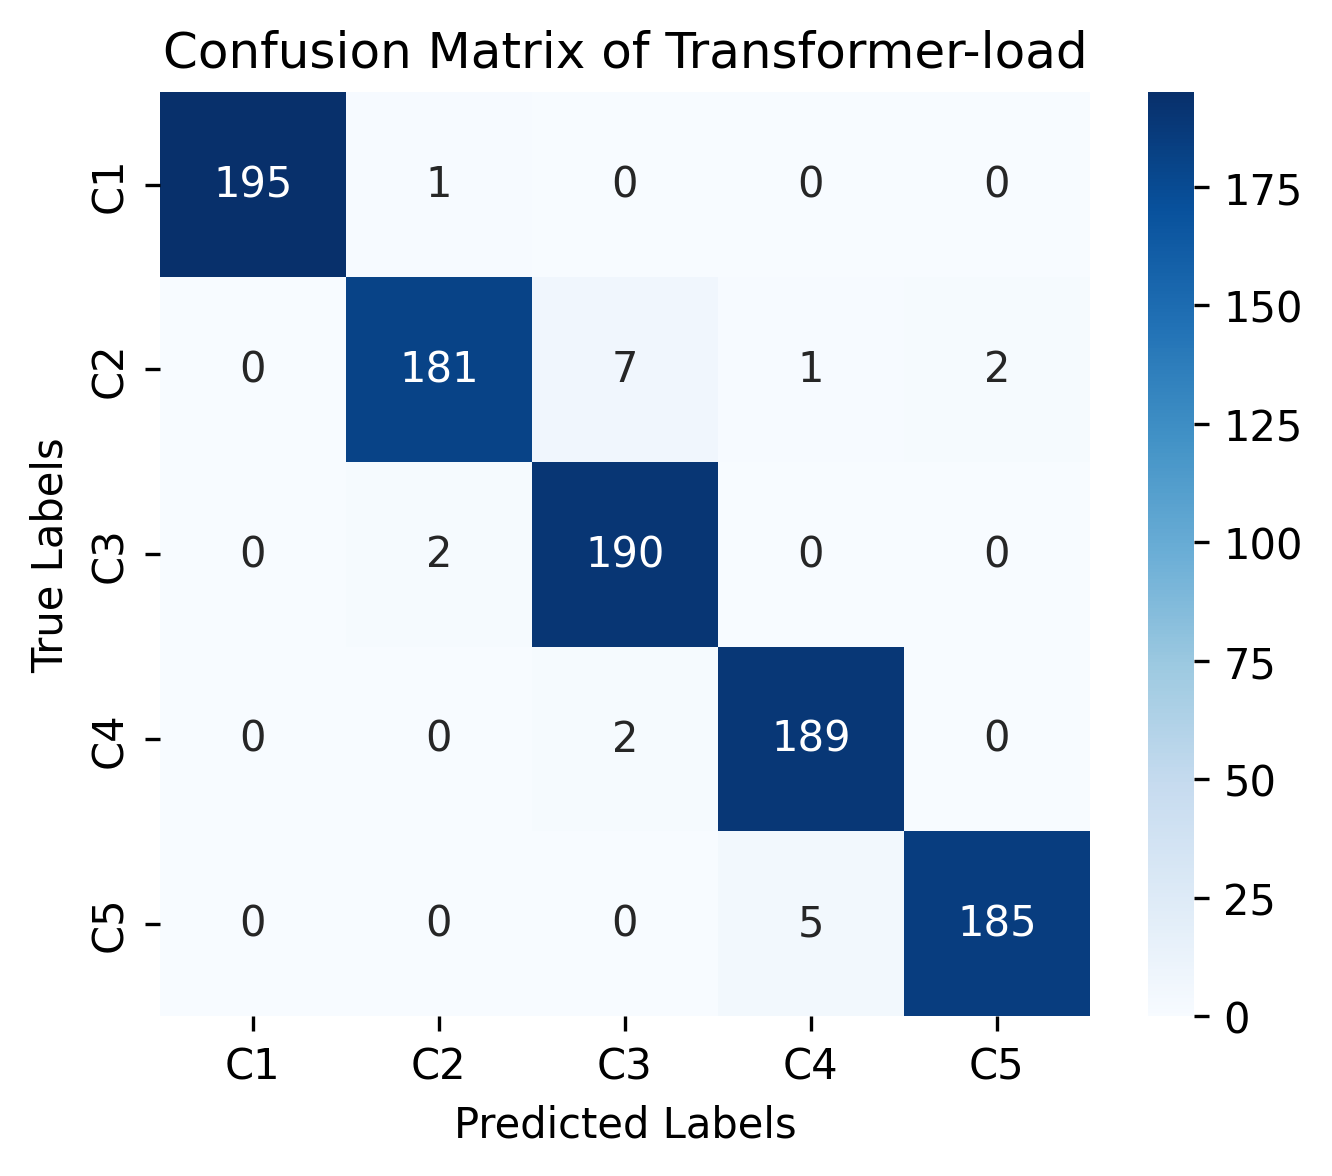

In [6]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
    #5: "C6",6: "C7",7: "C8",8: "C9",9: "C10",
}

# 绘制混淆矩阵
plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Transformer-load')
plt.savefig("transformer_confusion.png")
plt.show()